# Continuous self-report analysis
Rubia Guerra

Last updated: Apr 12th 2022

### Module definitions

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import glob
import re
import pandas as pd
import scipy.io as sio
import seaborn as sns

plt.style.use("seaborn")

%matplotlib inline

### Import data

In [2]:
def load_dataset(data_dir = '../EEG/data/p*'):
    subject_data_files = glob.glob(os.path.join(data_dir, 'joystick.mat'))
    subject_data_files.sort()
    
    subjects_data = []
    for subject_filename in subject_data_files:
        mat_contents = sio.loadmat(subject_filename)
        df = pd.DataFrame(mat_contents['var'], columns=['Timestamp', 'Feeltrace'])
        p_number = re.findall('p\d+', subject_filename) * df.shape[0]
        df['p_number'] = p_number
        subjects_data.append(df)
    
    return subjects_data

In [3]:
X_list = load_dataset()

In [4]:
X_list[0].head()

,Timestamp,Feeltrace,p_number
0,9437.0,74.0,p10
1,9451.0,74.0,p10
2,9471.0,74.0,p10
3,9511.0,75.0,p10
4,9548.0,74.0,p10


In [5]:
X = pd.concat(X_list)
X.head()

,Timestamp,Feeltrace,p_number
0,9437.0,74.0,p10
1,9451.0,74.0,p10
2,9471.0,74.0,p10
3,9511.0,75.0,p10
4,9548.0,74.0,p10


## Feeltrace analyses

### Boxplot

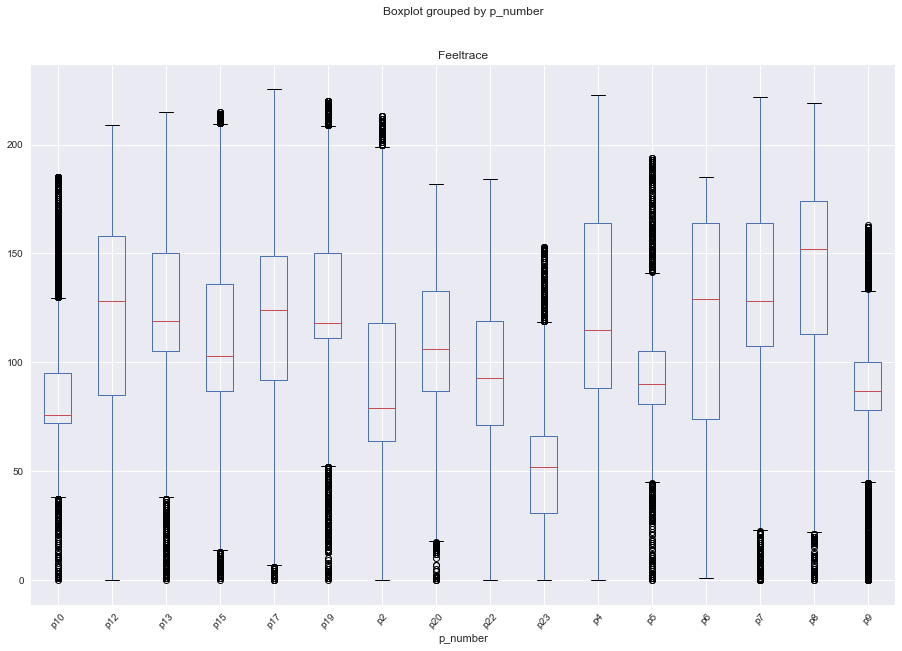

In [6]:
ax = X.boxplot(column='Feeltrace', by='p_number', rot=45, figsize=(15,10));

In [7]:
def plot_all_feeltrace(X, num_columns, figsize_per_row=None):
    X_by_participant = iter(X.groupby('p_number'))
    if figsize_per_row is None:
        figsize_per_row = (25, 15/num_columns)
    try:
        while True:
            # call plt.figure once per row
            fig = plt.figure(figsize=figsize_per_row)
            fig.subplots_adjust(hspace=0.4, wspace=0.4)
            for col in range(num_columns):
                pnum = next(X_by_participant)
                series  = pnum[1].Feeltrace
                ax = fig.add_subplot(1, num_columns, col+1)
                ax.plot(series)
                plt.title(pnum[0])
                plt.ylim([-10, 250])
    except StopIteration:
        pass

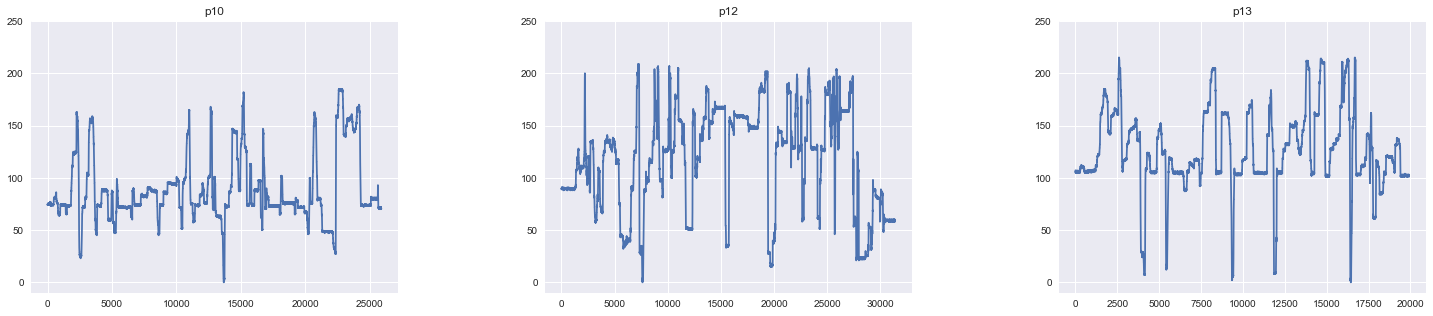

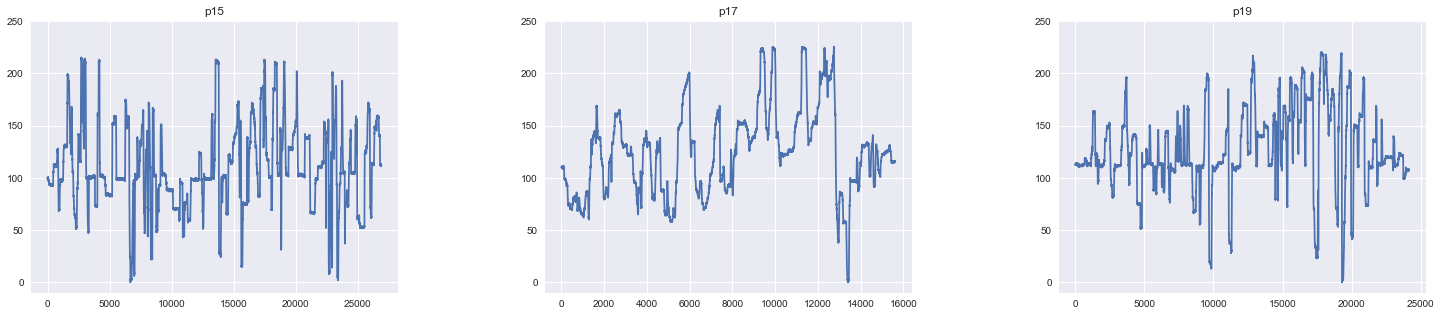

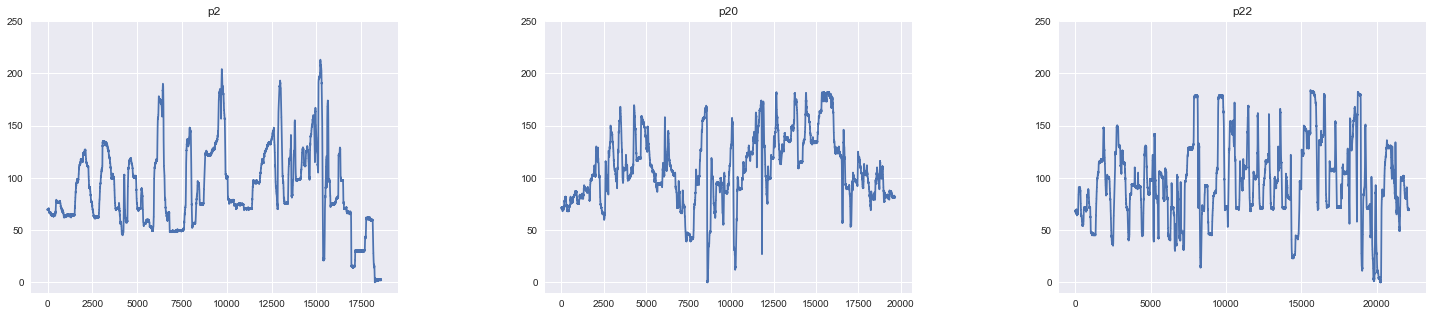

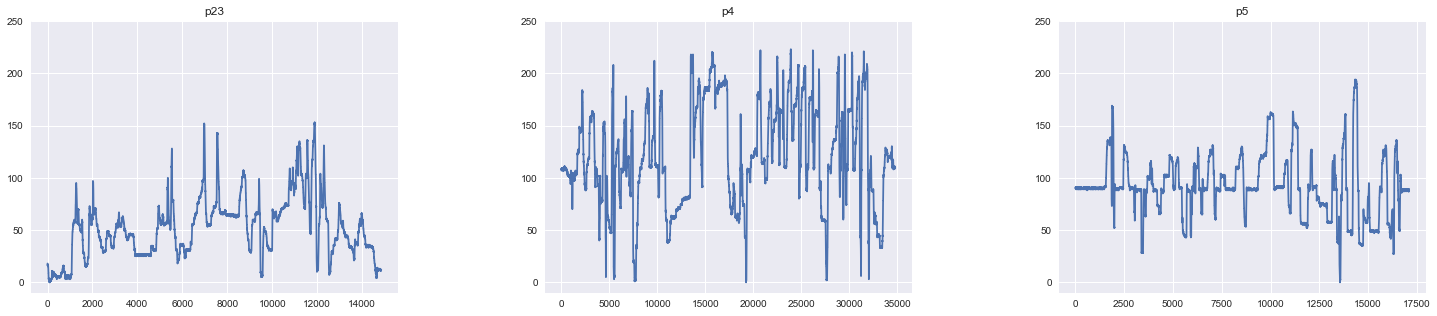

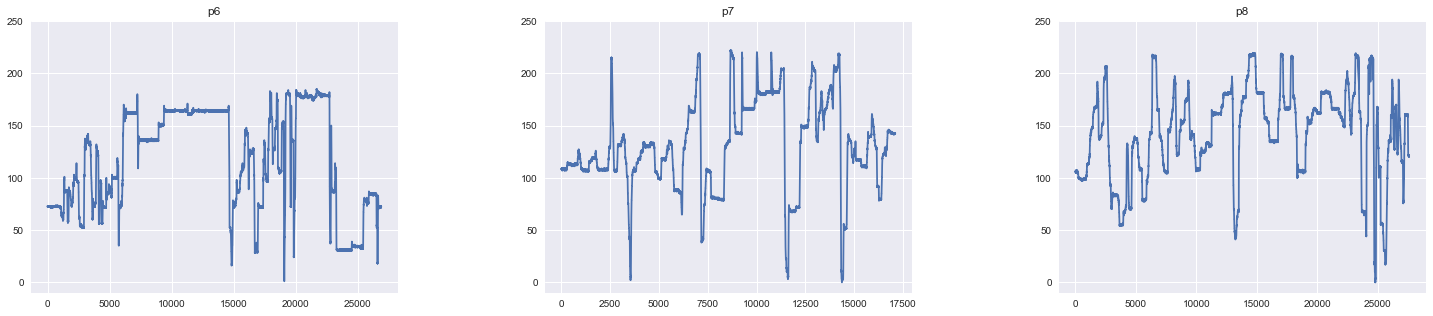

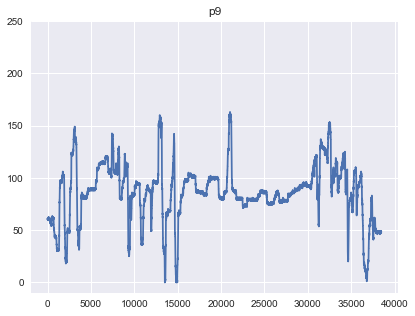

In [8]:
plot_all_feeltrace(X, 3)

### Autocorrelation analysis

Takeaways:
- Based on the plots below, there seems to be no strong effects of autocorrelation.
- Idea: we could use the last significant lag (e.g. the last lag above 0.2, but have to define this threshold) as a measure for "reaction time" in the continuous annotation pass. In other words, the strong autocorrelation for small lags suggest that the participant takes some time processing their emotions and generating an annotation.

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_autocorr(X, num_columns, lags, figsize_per_row=None):
    X_by_participant = iter(X.groupby('p_number'))
    if figsize_per_row is None:
        figsize_per_row = (25, 15/num_columns)
    try:
        while True:
            fig = plt.figure(figsize=figsize_per_row)
            fig.subplots_adjust(hspace=0.4, wspace=0.4)
            for col in range(num_columns):
                pnum = next(X_by_participant)
                series  = pnum[1].Feeltrace
                series = series.diff() # detrend
                series[0] = 0
                ax = fig.add_subplot(1, num_columns, col+1)
                plot_acf(series, ax=ax, lags=lags, title=pnum[0], zero=False) # autocorr for all lags < 1 min
                plt.ylim([-.5,1.15])
    except StopIteration:
        pass

#### Lags up to 1 min

Y-axis: Correlation coefficient (-1 to 1)
X-axis: lag index (0 to 1 min, Fs = 30Hz)

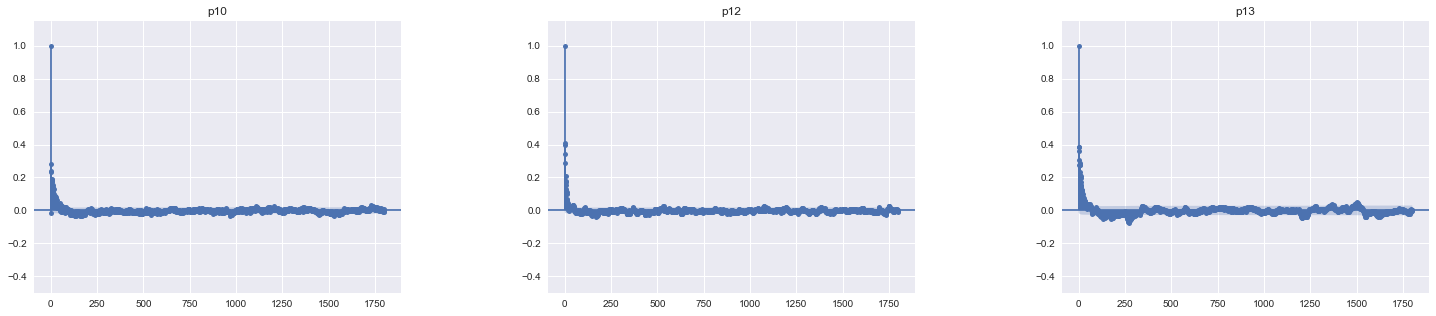

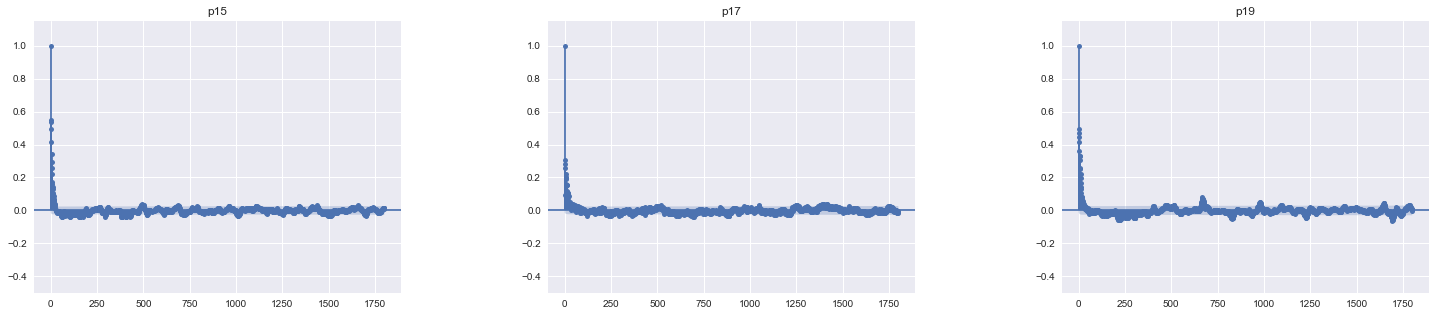

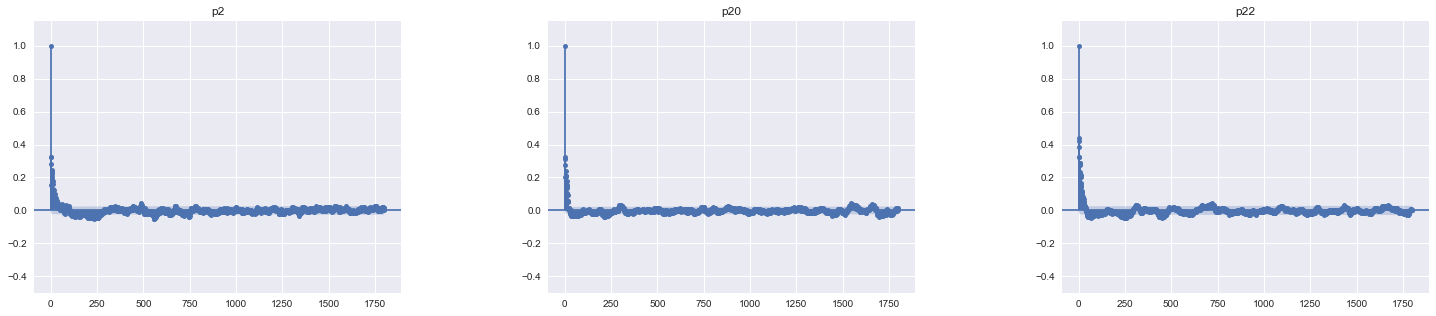

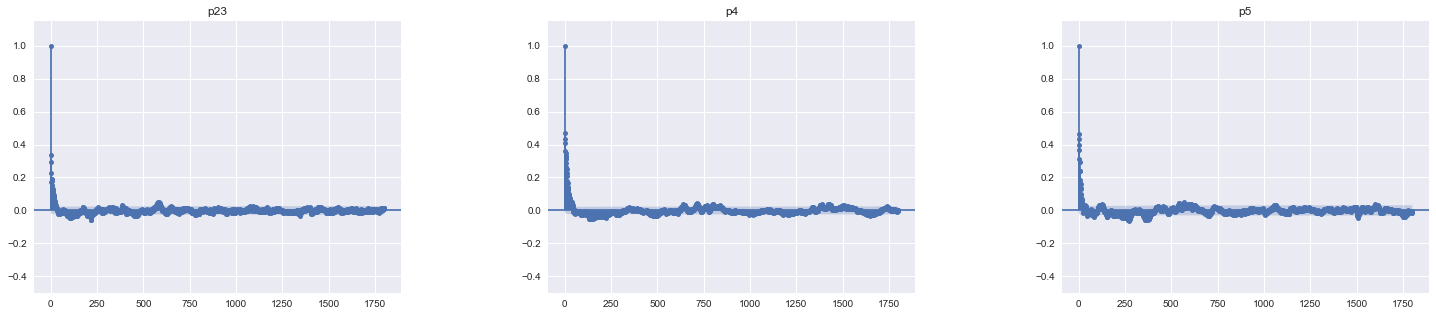

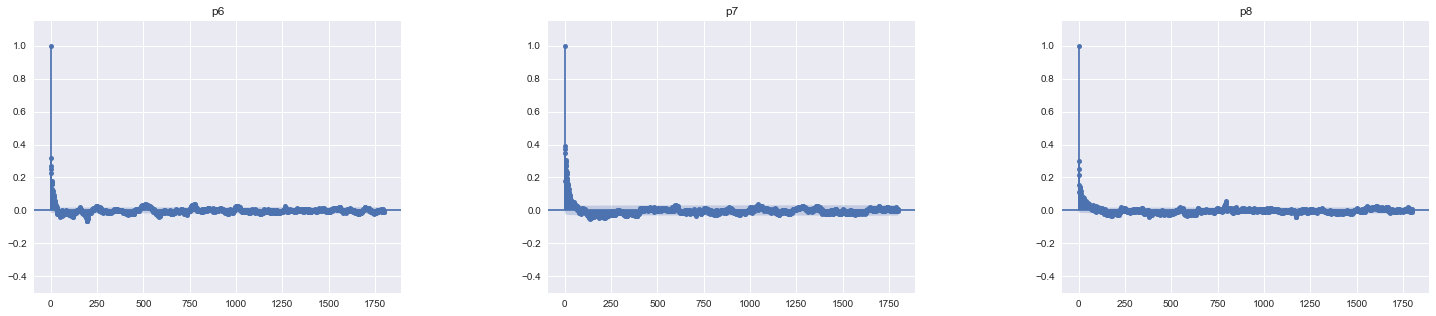

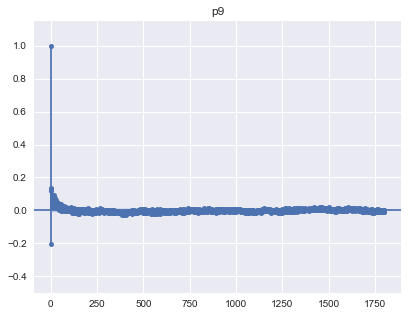

In [10]:
plot_autocorr(X, 3, np.arange(30*1*60))

#### Closer look on lags up to 2 seconds

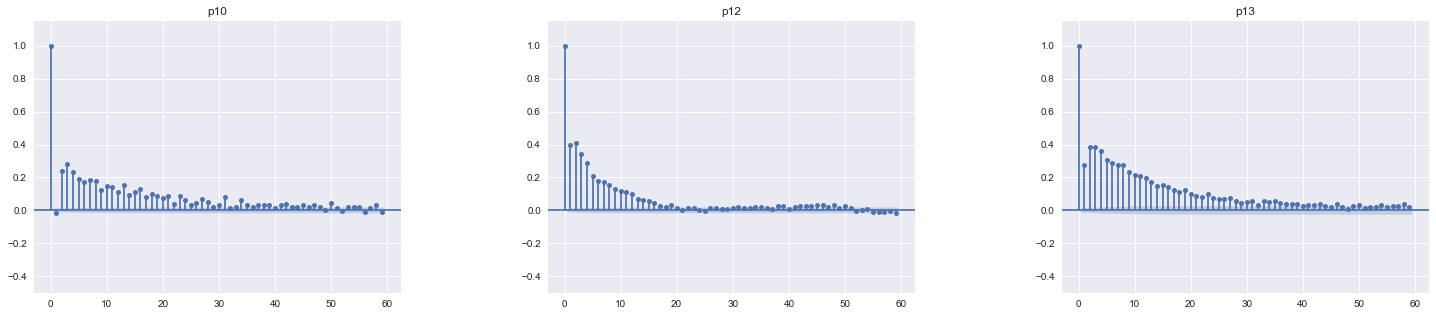

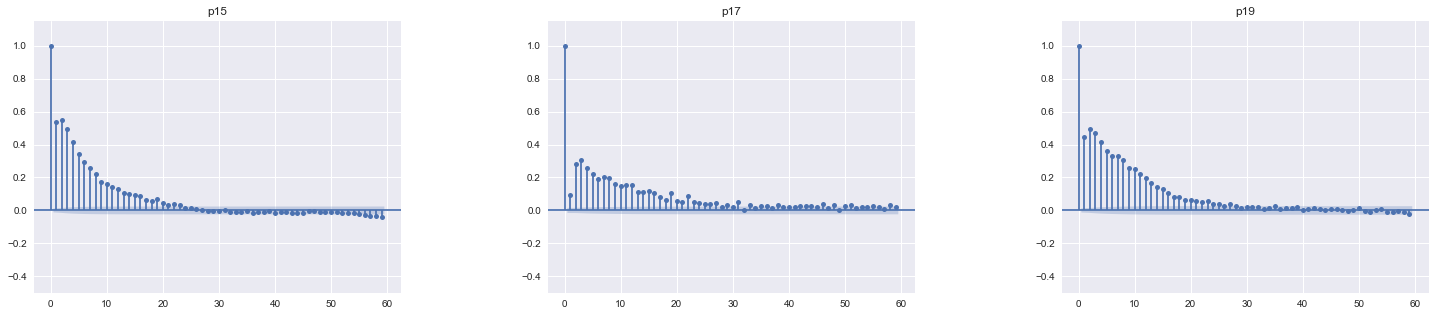

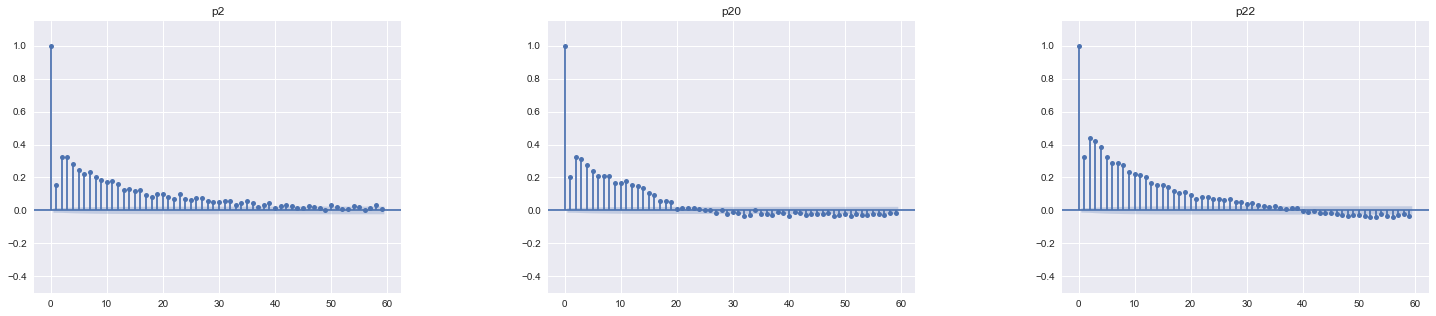

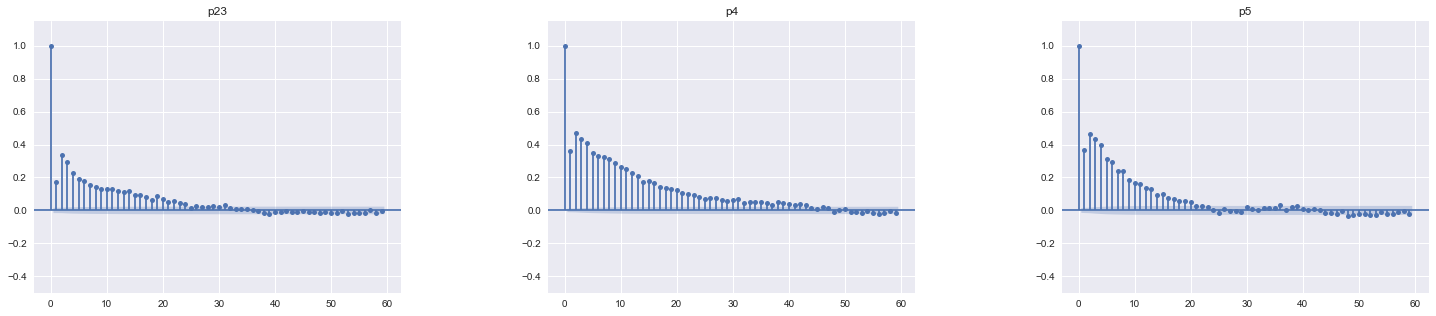

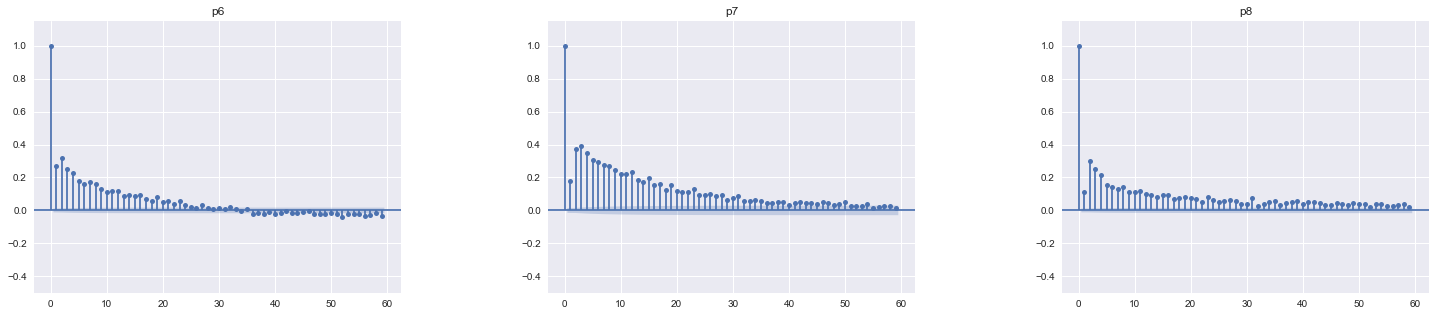

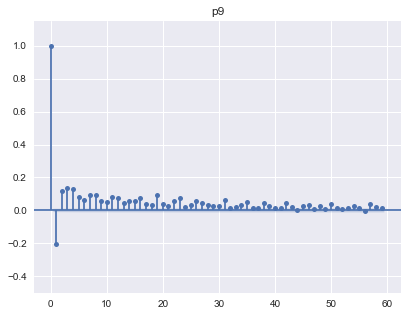

In [11]:
plot_autocorr(X, 3, np.arange(30*2))

#### Note on ACF confidence intervals

From [`statsmodels`](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) documentation:
    
    Confidence intervals for ACF values are generally placed at 2 standard errors around r_k. The formula used for standard error depends upon the situation. If the autocorrelations are being used to test for randomness of residuals as part of the ARIMA routine, the standard errors are determined assuming the residuals are white noise. The approximate formula for any lag is that standard error of each r_k = 1/sqrt(N). See section 9.4 of [1] for more details on the 1/sqrt(N) result. For more elementary discussion, see section 5.3.2 in [2]. For the ACF of raw data, the standard error at a lag k is found as if the right model was an MA(k-1). This allows the possible interpretation that if all autocorrelations past a certain lag are within the limits, the model might be an MA of order defined by the last significant autocorrelation. In this case, a moving average model is assumed for the data and the standard errors for the confidence intervals should be generated using Bartlett’s formula. For more details on Bartlett formula result, see section 7.2 in [1].


### VAR Model

Refer to _Ernst AF, Timmerman ME, Jeronimus BF, Albers CJ. Insight into individual differences in emotion dynamics with clustering. Assessment. 2021 Jun;28(4):1186-206._

*Adapted from [BioSciEconomist/ex VAR.py](https://gist.github.com/BioSciEconomist/197bd86ea61e0b4a49707af74a0b9f9c).

In [12]:
df = pd.DataFrame(X[X['p_number'] == 'p2']['Feeltrace'])
print(df.shape)  # (123, 8)
df.tail()

(18617, 1)


,Feeltrace
18612,2.0
18613,2.0
18614,2.0
18615,2.0
18616,2.0


In [13]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#------------------------------------------
# granger causality tests
#-----------------------------------------


# The basis behind Vector AutoRegression is that each of the time series in the 
# system influences each other. That is, you can predict the series with past 
# values of itself along with other series in the system.

# Using Granger’s Causality Test, it’s possible to test this relationship before 
# even building the model.

# Ho: past values of time series (X) DO NOT cause the other series (Y).


from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

/Users/rubiarg/.virtualenvs/cpsc554x/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/rubiarg/.virtualenvs/cpsc554x/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/rubiarg/.virtualenvs/cpsc554x/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/rubiarg/.virtualenvs/cpsc554x/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constrai

,Feeltrace_x
Feeltrace_y,1.0


In [14]:
# notes: 
# The row are the Response (Y) and the columns are the predictor series (X).

# For example, if you take the value 0.0003 in (row 1, column 2), it refers to 
# the p-value of pgnp_x causing rgnp_y. Whereas, the 0.000 in (row 2, column 1) 
# refers to the p-value of rgnp_y causing pgnp_x.


#-----------------------------------------
# cointegration
#-----------------------------------------

# When two or more time series are cointegrated, it means they have a long run, 
# statistically significant relationship.

# This is the basic premise on which Vector Autoregression(VAR) models is based on. 
# So, it’s fairly common to implement the cointegration test before starting to 
# build VAR models.

# more technically:
# Order of integration(d) is nothing but the number of differencing required to 
# make a non-stationary time series stationary.

# Now, when you have two or more time series, and there exists a linear combination
#  of them that has an order of integration (d) less than that of the individual 
# series, then the collection of series is said to be cointegrated.

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Feeltrace ::  2.9       > 4.1296    =>   False


In [15]:
#---------------------------------------
# training and validation data
#--------------------------------------

# The VAR model will be fitted on df_train and then used to forecast the next 4 
# observations. These forecasts will be compared against the actuals present in 
# test data.


nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(18613, 1)
(4, 1)


In [16]:
#------------------------------
# check for stationarity
#-----------------------------

# VAR model requires the time series you want to forecast to be stationary, 
# it is customary to check all the time series in the system for stationarity.

# Since, differencing reduces the length of the series by 1 and since all the 
# time series has to be of the same length, you need to difference all the series
#  in the system if you choose to difference at all.

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  
        
 # ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')       

# The ADF test confirms none of the time series is stationary. Let’s difference all 
# of them once and check again.

# 1st difference
df_differenced = df_train.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')
    
    
# After the first difference, Real Wages (Manufacturing) is still not stationary. 
# It’s critical value is between 5% and 10% significance level. All of the series 
# in the VAR model should have the same number of observations. So, we are left with 
# one of two choices. That is, either proceed with 1st differenced series or 
# difference all the series one more time.

# Second Differencing
df_differenced = df_differenced.diff().dropna()

# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Feeltrace" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8036
 No. Lags Chosen       = 39
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Feeltrace" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.7814
 No. Lags Chosen       = 38
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Feeltrace" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signific

In [ ]:
#---------------------------------------
# fitting the order of the VAR
#--------------------------------------

# To select the right order of the VAR model, we iteratively fit increasing orders 
# of VAR model and pick the order that gives a model with least AIC.

model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    
# In the above output, the AIC drops to lowest at lag 4, then increases at 
# lag 5 and then continuously drops further. (more negative = 'smaller' AIC)

#---------------------------------
# alterntative: auto fit
#---------------------------------

x = model.select_order(maxlags=12)
x.summary()


#----------------------------------
# fit VAR(4)
#---------------------------------

model_fitted = model.fit(4)
model_fitted.summary()

In [ ]:
#---------------------------------------
# check for remaining serial correlation
#---------------------------------------


# Serial correlation of residuals is used to check if there is any leftover pattern 
# in the residuals (errors). If there is any correlation left in the residuals, then,
# there is some pattern in the time series that is still left to be explained by the
# model. In that case, the typical course of action is to either increase the order
# of the model or induce more predictors into the system or look for a different 
# algorithm to model the time series.

# A common way of checking for serial correlation of errors can be measured using 
# the Durbin Watson’s Statistic.

# The value of this statistic can vary between 0 and 4. The closer it is to the value 
# 2, then there is no significant serial correlation. The closer to 0, there is a 
# positive serial correlation, and the closer it is to 4 implies negative serial 
# correlation.

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

# for col, val in zip(df.columns, out):
#    print(adjust(col), ':', round(val, 2))
    
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))
    
#--------------------------------------
# forecasting
#--------------------------------------

# In order to forecast, the VAR model expects up to the lag order number of 
# observations from the past data. This is because, the terms in the VAR model 
# are essentially the lags of the various time series in the dataset, so you 
# need to provide it as many of the previous values as indicated by the lag order
# used by the model.

# Get the lag order (we already know this)
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast


# The forecasts are generated but it is on the scale of the training data used by 
# the model. So, to bring it back up to its original scale, you need to de-difference 
# it as many times you had differenced the original input data.

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]


#---------------------------
# plot forecasts
#---------------------------


fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


#-----------------------------------------
# forecast accuracy
#-----------------------------------------


from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

#### Gaussian Mixture Model

### Emotion dynamics

#### Defining emotion dynamics features
Refer to _Houben M, Van Den Noortgate W, Kuppens P. The relation between short-term emotion dynamics and psychological well-being: A meta-analysis. Psychological bulletin. 2015 Jul;141(4):901._

- **Emotional inertia:** refers to how well the intensity of an emotional state can be predicted from the emotional state at a previous moment.
- **Emotional instability:** refers to the magnitude of emotional changes from one moment to the next. An individual characterized by high levels of instability experiences larger emotional shifts from one moment to the next, resulting in a more unstable emotional life.
- **Emotional variability:** refers to the range or amplitude of someone’s emotional states across time. An individual characterized by higher levels of emotional variability experiences emotions that reach more extreme levels and shows larger emotional deviations from his or her average emotional level

In [17]:
from statsmodels.tsa import stattools

class EmotionDynamics:
    def __init__(self, Fs=30, interval=300):
        self.lag = int(Fs*interval*1e-1) # feeltrace sampling rate x 300 ms

    def emotional_variability(self, X):
        return np.std(X)

    def emotional_instability(self, X):
        return np.sum((X[1:] - X[:-1])**2)/(len(X)-1) # MSSD

    def emotional_inertia(self, X, lag=None):
        if lag is None:
            lag = self.lag
        try:
            return stattools.acf(X, nlags=lag)[lag] # Autocorrelation
        except IndexError:
            return stattools.acf(X, nlags=700)[700] # Autocorrelation

    
    def get_parameters(self, X):
        X = np.array(X)
        parameters = {'Inertia':'', 'Instability':'', 'Variability':''}
        parameters['Inertia'] = self.emotional_inertia(X)
        parameters['Instability'] = self.emotional_instability(X)
        parameters['Variability'] = self.emotional_variability(X)
        return parameters

In [18]:
ED = EmotionDynamics()

In [19]:
ED.get_parameters(X_list[1]['Feeltrace'])

{'Inertia': 0.12750613717182116,
 'Instability': 1.2786323969679598,
 'Variability': 49.07772720654508}

In [20]:
X_ed = []
for subject in X_list:
    feeltrace = np.array(subject['Feeltrace'])
    X_ed.append(ED.get_parameters(feeltrace))

In [21]:
X_ed = pd.DataFrame(X_ed)
X_ed

,Inertia,Instability,Variability
0,0.017359,0.593234,32.349176
1,0.127506,1.278632,49.077727
2,0.111697,0.951712,38.263004
3,0.087622,1.989445,40.816129
4,-0.005488,0.761333,42.022961
5,0.012039,1.315396,39.632455
6,0.067442,0.714600,39.557379
7,0.288932,0.922316,33.193777
8,-0.136392,1.056519,38.449633
9,0.156959,0.808034,29.005620


In [22]:
max_ = pd.Series(map(lambda x: x*1.2 if  x > 0 else x*0.8, X_ed.max()), ['Inertia', 'Instability', 'Variability'])
min_ = pd.Series(map(lambda x: x*1.2 if  x < 0 else x*0.8, X_ed.min()), ['Inertia', 'Instability', 'Variability'])

#### Pairplot analysis

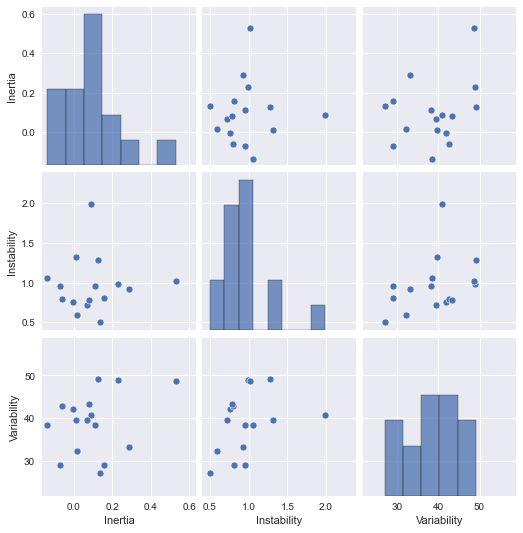

In [23]:
grid = sns.pairplot(X_ed);

# x-axis limits
grid.axes[0,0].set_xlim((min_.Inertia,max_.Inertia))
grid.axes[0,1].set_xlim((min_.Instability,max_.Instability))
grid.axes[0,2].set_xlim((min_.Variability,max_.Variability))
grid.axes[1,0].set_xlim((min_.Inertia,max_.Inertia))
grid.axes[1,1].set_xlim((min_.Instability,max_.Instability))
grid.axes[1,2].set_xlim((min_.Variability,max_.Variability))
grid.axes[2,0].set_xlim((min_.Inertia,max_.Inertia))
grid.axes[2,1].set_xlim((min_.Instability,max_.Instability))
grid.axes[2,2].set_xlim((min_.Variability,max_.Variability))

# y-axis limits
grid.axes[0,0].set_ylim((min_.Inertia,max_.Inertia))
grid.axes[0,1].set_ylim((min_.Inertia,max_.Inertia))
grid.axes[0,2].set_ylim((min_.Inertia,max_.Inertia))
grid.axes[1,0].set_ylim((min_.Instability,max_.Instability))
grid.axes[1,1].set_ylim((min_.Instability,max_.Instability))
grid.axes[1,2].set_ylim((min_.Instability,max_.Instability))
grid.axes[2,0].set_ylim((min_.Variability,max_.Variability))
grid.axes[2,1].set_ylim((min_.Variability,max_.Variability))
grid.axes[2,2].set_ylim((min_.Variability,max_.Variability));

#### Data preprocessing: scaling
Standardize features by removing the mean and scaling to unit variance.

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ed)
X_scaled = pd.DataFrame(X_scaled, columns={'Inertia', 'Instability', 'Variability'})
X_scaled.head()

,Instability,Variability,Inertia
0,-0.527612,-1.097853,-0.950685
1,0.187769,0.930514,1.480287
2,0.085095,-0.036975,-0.091295
3,-0.071268,3.034094,0.279722
4,-0.675998,-0.600382,0.455097


In [25]:
max_scaled = pd.Series(map(lambda x: x*1.2 if  x > 0 else x*0.8, X_scaled.max()), 
                       ['Inertia', 'Instability', 'Variability'])
min_scaled = pd.Series(map(lambda x: x*1.2 if  x < 0 else x*0.8, X_scaled.min()), 
                       ['Inertia', 'Instability', 'Variability'])

#### 3D scatterplot

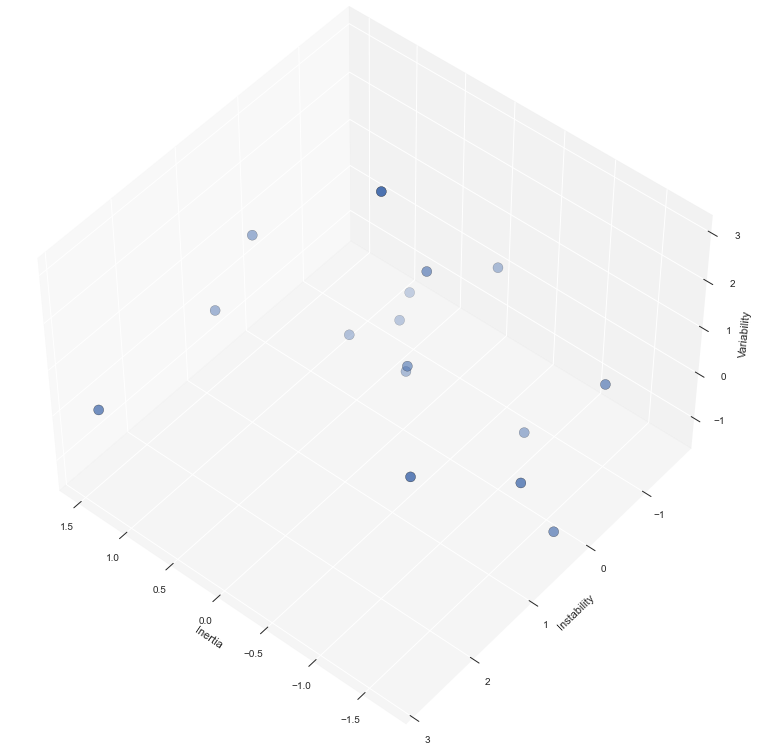

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=130, auto_add_to_figure=False, facecolor='w')
fig.add_axes(ax)

ax.scatter(X_scaled.Inertia, X_scaled.Instability, X_scaled.Variability, 
           cmap=plt.cm.nipy_spectral, edgecolor="k", s=100)

ax.set_xlabel('Inertia')
ax.set_ylabel('Instability')
ax.set_zlabel('Variability')

plt.show()

#### Principal Component Analysis

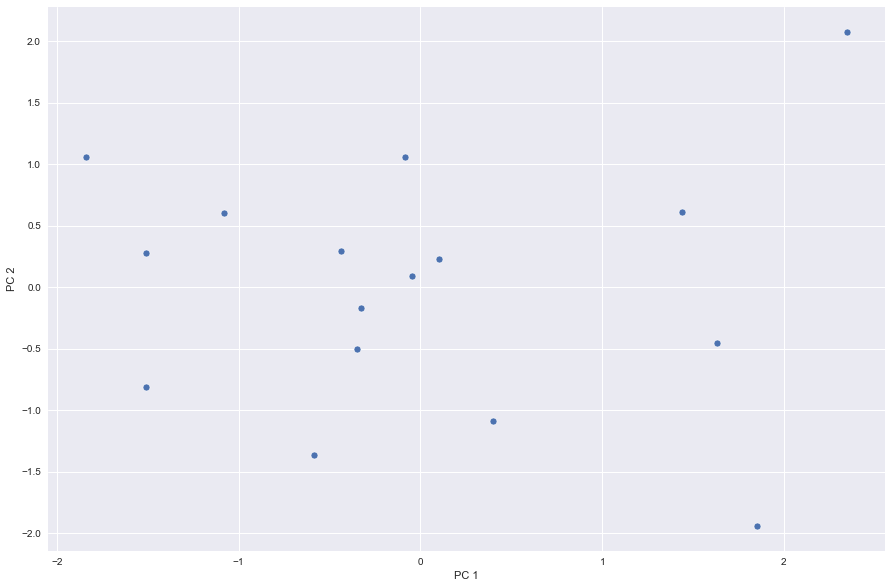

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
X_PCA = pca.transform(X_scaled)

fig = plt.figure(figsize=(15,10))
sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1]);
plt.xlabel('PC 1')
plt.ylabel('PC 2');

#### Gaussian Mixture Model

- Gaussian Mixture Models using information-theoretic criteria (BIC).
- Model selection concerns both the covariance type and the number of components in the model.
- Unlike Bayesian procedures, such inferences are prior-free.

*Adapted from [Gaussian Mixture Model Selection](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#)

In [28]:
import itertools
from scipy import linalg
from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_scaled)
        bic.append(gmm.bic(X_scaled))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)

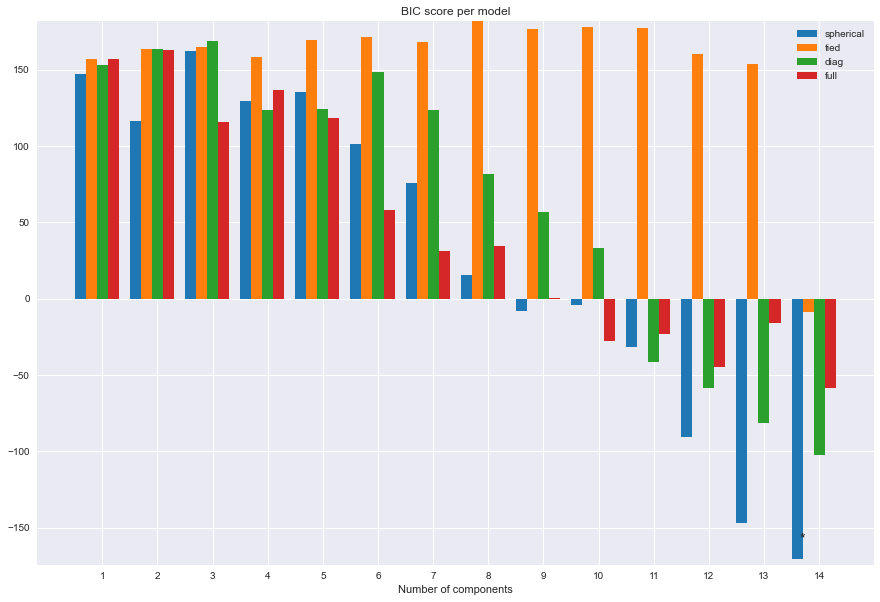

In [29]:
clf = best_gmm

color_iter = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 10))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
plt.xlabel("Number of components")
plt.legend([b[0] for b in bars], cv_types);

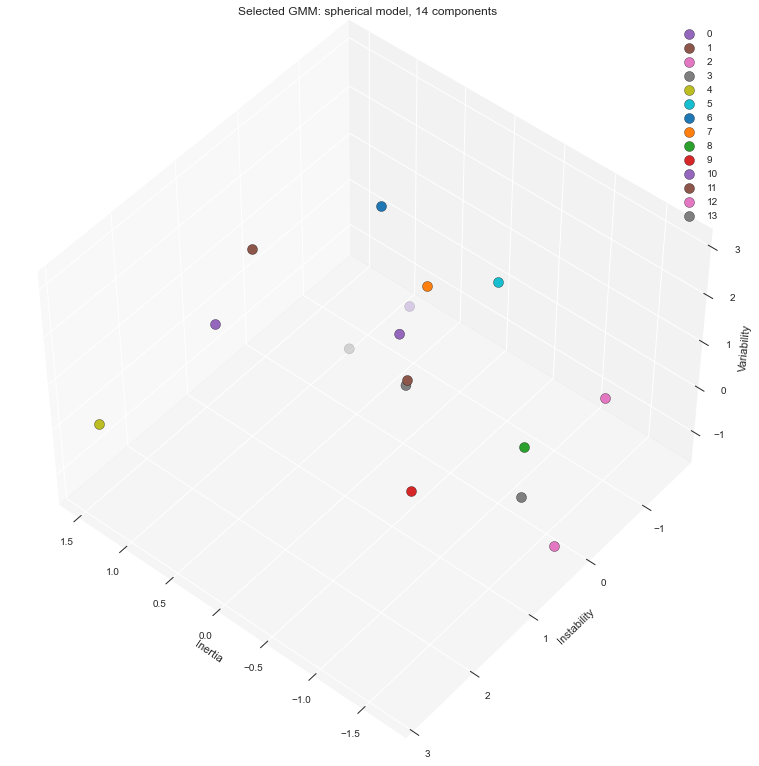

In [30]:
# Plot the winner
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=130, auto_add_to_figure=False, facecolor='w')
fig.add_axes(ax)
Y_ = clf.predict(X_scaled)

for i, (mean, color) in enumerate(zip(clf.means_, color_iter)):
    if not np.any(Y_ == i):
        continue
    ax.scatter(X_scaled.Inertia.loc[Y_ == i], X_scaled.Instability.loc[Y_ == i], 
               X_scaled.Variability.loc[Y_ == i], s=100, color=color, edgecolor="k")

plt.legend(range(len(clf.means_)))
ax.set_xlabel('Inertia')
ax.set_ylabel('Instability')
ax.set_zlabel('Variability')

plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)


plt.show()

#### Within-participant analysis

The main takeaway so far seems to be that there are no direct archetypes or patterns of response. This seems to suggest that personalized models make sense, given that each participant's response is distinct.

Below is an attempt to address KM's comment:

```Is there any more evidence that it is indeed individualized? Is within-participant behavior consistent?```

Each feeltrace is split in 30 sec chunks, then analyzed within participant.

In [31]:
participant_split = {}
n_samples = int(30*5*60) # sampling rate x n_seconds (3 min)
for index, subject in enumerate(X_list):
    feeltrace = np.array(subject['Feeltrace'])
    n_chunks = int(len(feeltrace)/n_samples)
    participant_split[index] = np.array_split(feeltrace, n_chunks)

In [32]:
ed_participant = {}
grids = []
X_participant_dfs = []

for index, participant in enumerate(participant_split.items()):
    ed_participant[index] = list(map(ED.get_parameters, participant[1]))
    X_participant_dfs.append(pd.DataFrame(ed_participant[index]))
    X_participant_dfs[index]['Participant'] = X_participant_dfs[index].shape[0] * [index]
    X_participant_dfs[index]['Window'] = list(map(lambda x: x, range(X_participant_dfs[index].shape[0])))

In [33]:
from functools import reduce
X_participants = reduce(lambda x, y: pd.concat([x,y], ignore_index = True, sort = False), X_participant_dfs)

In [49]:
X_participants[['Inertia', 'Instability', 'Variability']].head()

,Inertia,Instability,Variability
0,-0.006799,0.562249,24.325250
1,0.021048,0.624189,38.349309
2,-0.161445,1.079878,39.644436
3,-0.190638,0.983516,46.210123
4,0.327486,1.772766,54.534712


In [35]:
max_ = pd.Series(map(lambda x: x*1.2 if  x > 0 else x*0.8, X_participants[['Inertia', 'Instability', 'Variability']].max()), ['Inertia', 'Instability', 'Variability'])
min_ = pd.Series(map(lambda x: x*1.2 if  x < 0 else x*0.8, X_participants[['Inertia', 'Instability', 'Variability']].min()), ['Inertia', 'Instability', 'Variability'])

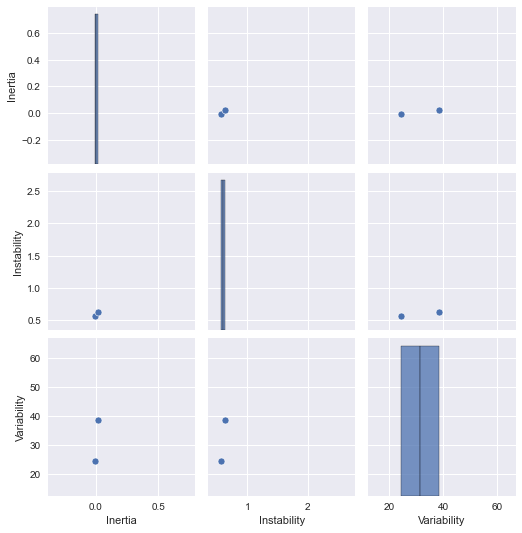

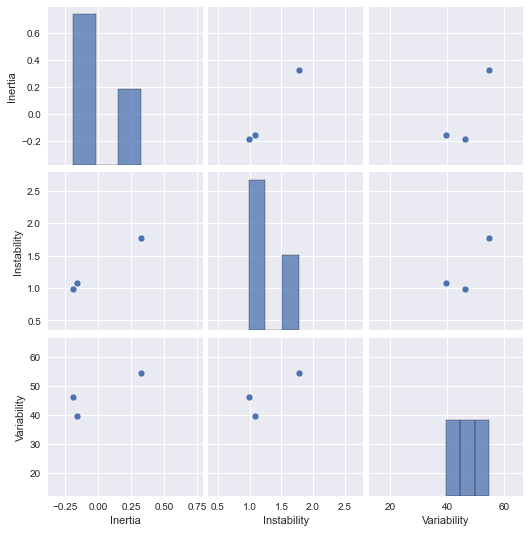

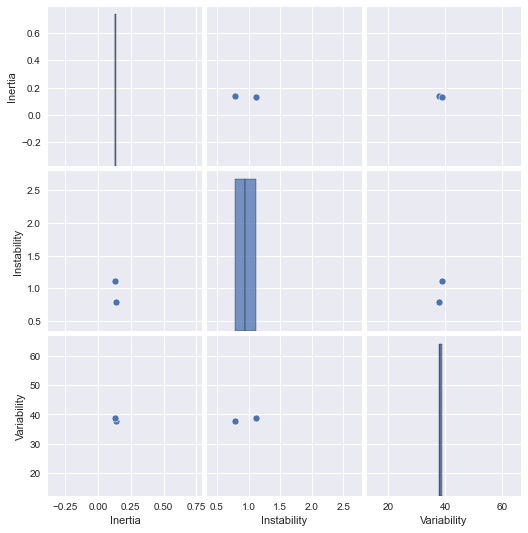

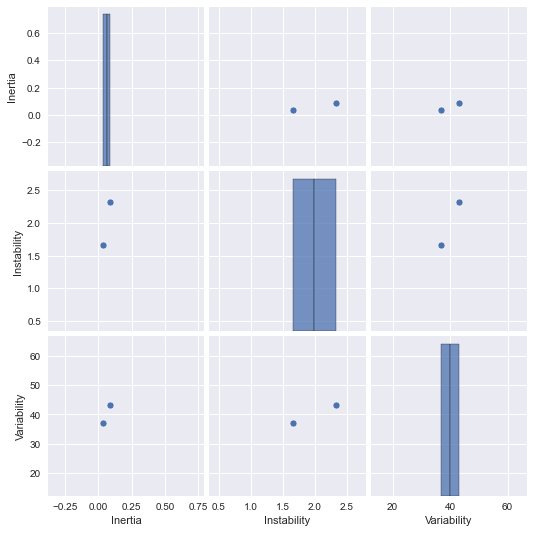

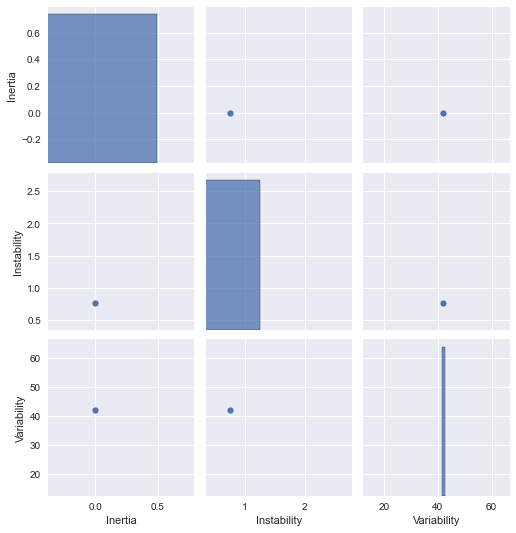

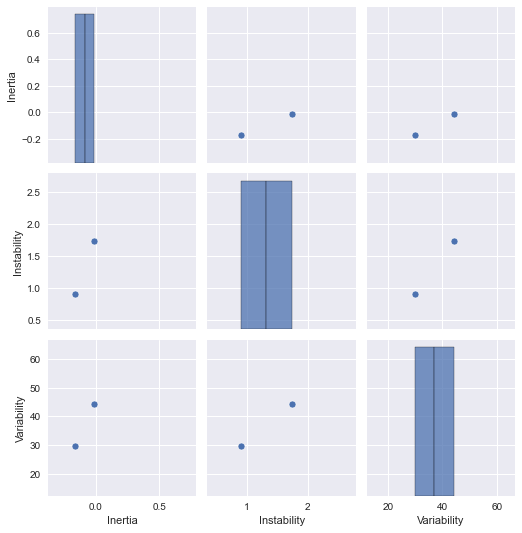

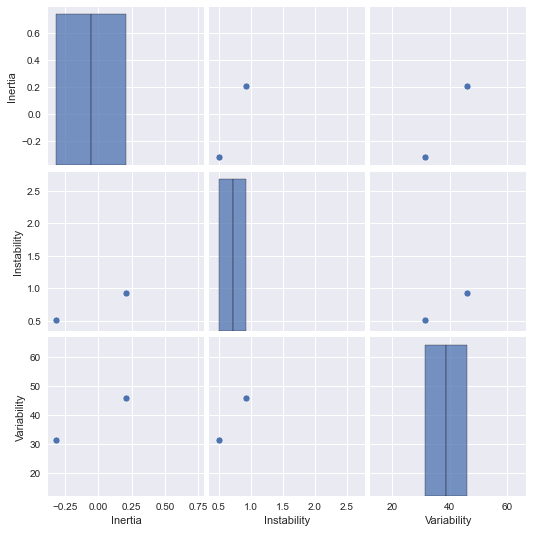

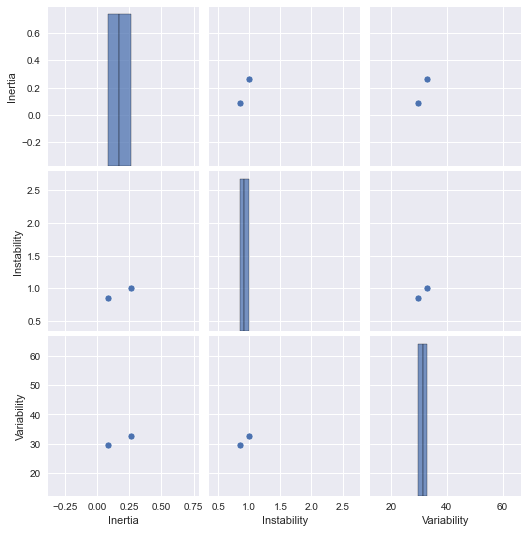

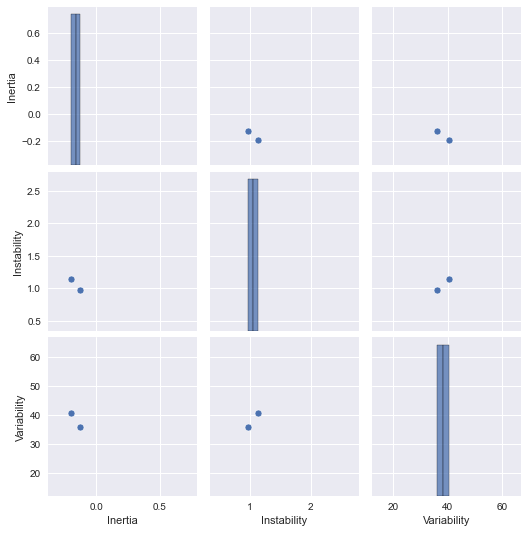

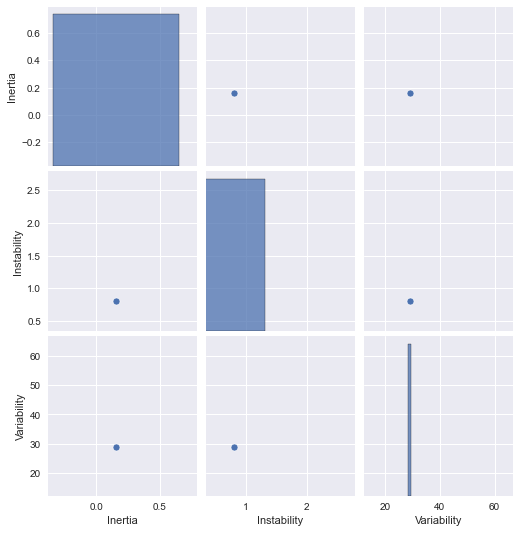

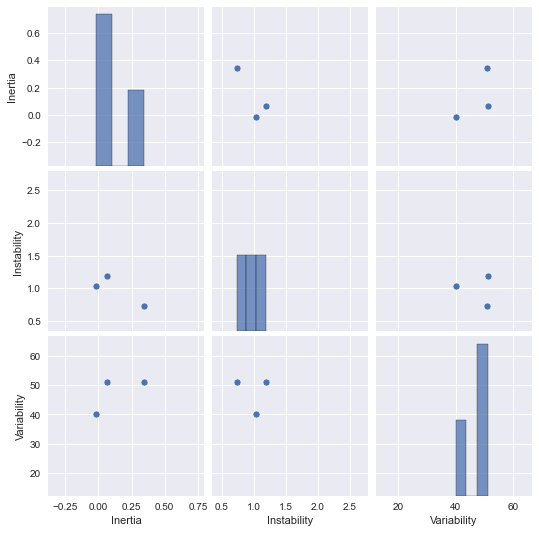

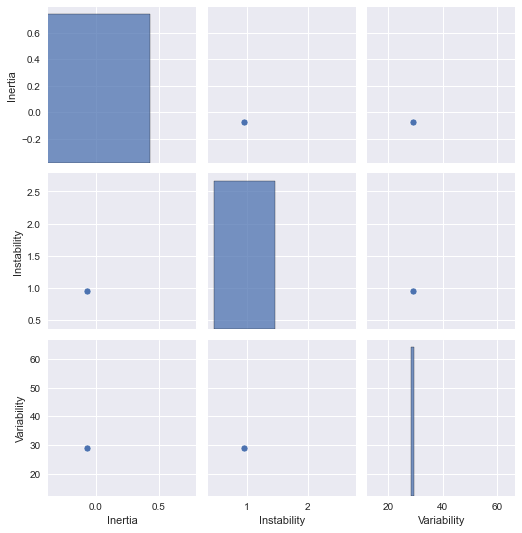

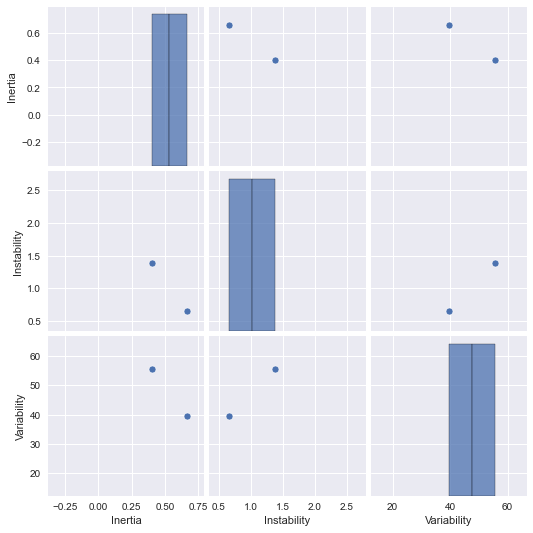

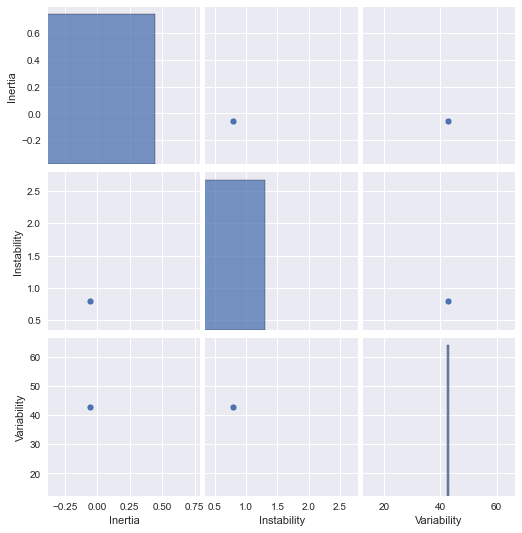

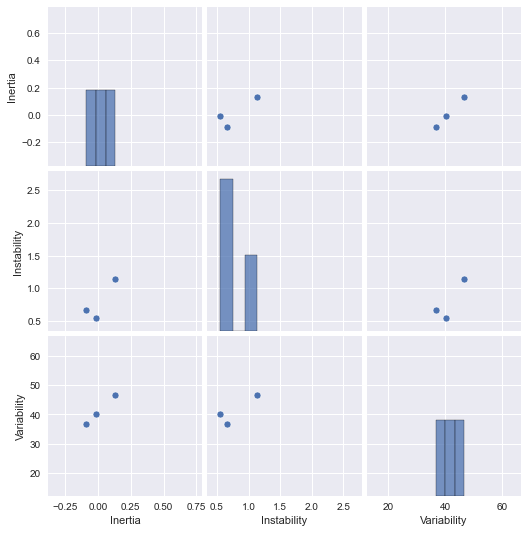

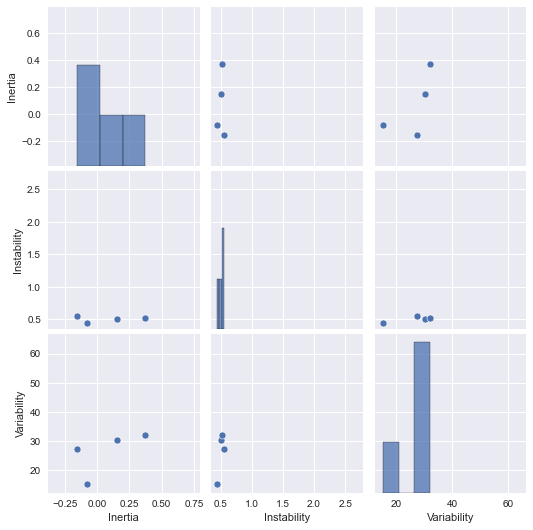

In [36]:
for index, participant in enumerate(participant_split.items()):    
    X_participant = pd.DataFrame(ed_participant[index])
    grid = sns.pairplot(X_participant);# x-axis limits
    grid.axes[0,0].set_xlim((min_.Inertia,max_.Inertia))
    grid.axes[0,1].set_xlim((min_.Instability,max_.Instability))
    grid.axes[0,2].set_xlim((min_.Variability,max_.Variability))
    grid.axes[1,0].set_xlim((min_.Inertia,max_.Inertia))
    grid.axes[1,1].set_xlim((min_.Instability,max_.Instability))
    grid.axes[1,2].set_xlim((min_.Variability,max_.Variability))
    grid.axes[2,0].set_xlim((min_.Inertia,max_.Inertia))
    grid.axes[2,1].set_xlim((min_.Instability,max_.Instability))
    grid.axes[2,2].set_xlim((min_.Variability,max_.Variability))

    # y-axis limits
    grid.axes[0,0].set_ylim((min_.Inertia,max_.Inertia))
    grid.axes[0,1].set_ylim((min_.Inertia,max_.Inertia))
    grid.axes[0,2].set_ylim((min_.Inertia,max_.Inertia))
    grid.axes[1,0].set_ylim((min_.Instability,max_.Instability))
    grid.axes[1,1].set_ylim((min_.Instability,max_.Instability))
    grid.axes[1,2].set_ylim((min_.Instability,max_.Instability))
    grid.axes[2,0].set_ylim((min_.Variability,max_.Variability))
    grid.axes[2,1].set_ylim((min_.Variability,max_.Variability))
    grid.axes[2,2].set_ylim((min_.Variability,max_.Variability))